In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_generator():
    z = Input(shape=(100,)) # noize
    c = Input(shape=(10,)) # condition. In this case, c is supposed to be a one-hot vector of CIFAR-10
    merged_input = Concatenate()([z, c])

    hid = Dense(128 * 8 * 8, activation='relu')(merged_input)    
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Reshape((8, 8, 128))(hid)
    
    hid = Conv2D(128, kernel_size=4, strides=1,padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)    
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)    
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid) # 32, 32, 3
    out = Activation("tanh")(hid)


    model = Model(inputs=[z, c], outputs=out)
    model.summary()

    return model, out

In [3]:
def get_discriminator():
    x = Input(shape=(32, 32, 3))
    c = Input(shape=(10,))
    hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

    hid = Flatten()(hid)

    c = Input(shape=(10,))
    merged_layer = Concatenate()([hid, c])
    hid = Dense(512, activation='relu')(merged_layer)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Dropout(0.4)(hid)
    out = Dense(1, activation='sigmoid')(hid)

    model = Model(inputs=[x, c], outputs=out)
    model.summary()

    return model, out

In [4]:
# --------
# Prepare some utilities
# --------

from keras.preprocessing import image

def one_hot_encode(y):
    z = np.zeros((len(y), 10))
    idx = np.arange(len(y))
    z[idx, y] = 1
    return z

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

def generate_random_labels(n):
    y = np.random.choice(10, n)
    y = one_hot_encode(y)
    return y

tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
  
def show_samples():
    fig, axs = plt.subplots(5, 6, figsize=(10,6))
    fig.patch.set_facecolor('white') # set background color white
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    #fig, axs = plt.subplots(5, 6)
    #fig.tight_layout()
    for classlabel in range(10):
        row = int(classlabel / 2)
        coloffset = (classlabel % 2) * 3
        lbls = one_hot_encode([classlabel] * 3)
        noise = generate_noise(3, 100)
        gen_imgs = generator.predict([noise, lbls])

        for i in range(3):
            # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[i], scale=True)
            axs[row,i + coloffset].imshow(img)
            axs[row,i + coloffset].axis('off')
            if i ==1:
                axs[row,i+coloffset].set_title(tags[classlabel])
    plt.show()
    plt.close()  

In [5]:
# -------
# Compile discriminator
# -------
discriminator, disc_out = get_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])


# --------
# Compile combined model with untrainable discriminator
# --------
discriminator.trainable = False

combined_input = Input(shape=(100,))
combined_condition = Input(shape=(10,))
generator, gen_out = get_generator()
x = generator([combined_input, combined_condition])
combined_out = discriminator([x, combined_condition])
combined = Model(inputs=[combined_input, combined_condition], output=combined_out)
combined.summary()

combined.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 128)  512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 128)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 32, 3)    2970755     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            1847169     model_2[1][0]                    
          

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`


In [6]:
# --------
# Prepare data
# -------

BATCH_SIZE = 32

# # Get training images
(X_train, c_train), (X_test, c_test) = cifar10.load_data()

# Normalize data
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5
# 1hot encode labels
c_train = one_hot_encode(c_train[:,0])
c_test = one_hot_encode(c_test[:,0])

print ("Training shape: {}".format(X_train.shape))
print ("Test     shape: {}".format(X_test.shape))
 
num_train_batches = X_train.shape[0] // BATCH_SIZE
num_test_batches = X_test.shape[0] // BATCH_SIZE

Training shape: (50000, 32, 32, 3)
Test     shape: (10000, 32, 32, 3)


In [7]:
# --------
# Log when learning started
# --------
import datetime
JST = datetime.timezone(datetime.timedelta(hours=+9), 'JST')
start_time = datetime.datetime.now(JST)
print(start_time)

2018-10-17 13:16:29.848434+09:00


Training started.


/root/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1; Gen. Loss: 0.671; Disc. Loss: 0.654, Acc: 0.866 (TEST)
Epoch: 2; Gen. Loss: 0.621; Disc. Loss: 0.630, Acc: 0.924 (TEST)
Epoch: 3; Gen. Loss: 0.661; Disc. Loss: 0.680, Acc: 0.595 (TEST)
Epoch: 4; Gen. Loss: 0.742; Disc. Loss: 0.732, Acc: 0.404 (TEST)
Epoch: 5; Gen. Loss: 0.652; Disc. Loss: 0.640, Acc: 0.671 (TEST)


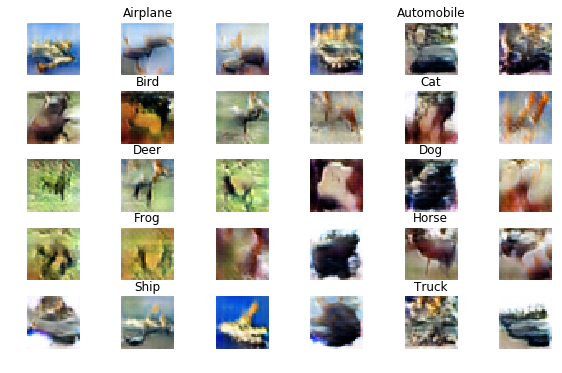

Epoch: 6; Gen. Loss: 0.609; Disc. Loss: 0.617, Acc: 0.678 (TEST)
Epoch: 7; Gen. Loss: 0.807; Disc. Loss: 0.785, Acc: 0.518 (TEST)
Epoch: 8; Gen. Loss: 0.840; Disc. Loss: 0.830, Acc: 0.471 (TEST)
Epoch: 9; Gen. Loss: 1.119; Disc. Loss: 0.899, Acc: 0.470 (TEST)
Epoch: 10; Gen. Loss: 0.363; Disc. Loss: 0.571, Acc: 0.714 (TEST)


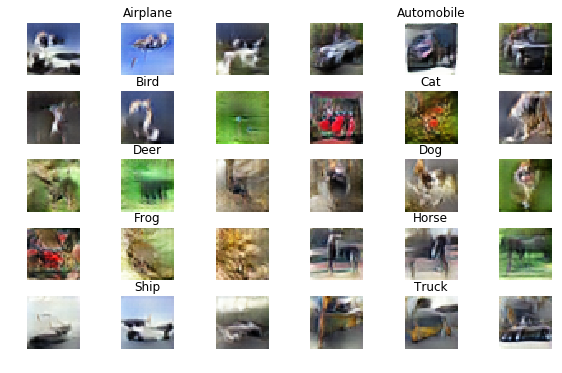

Epoch: 11; Gen. Loss: 0.634; Disc. Loss: 0.665, Acc: 0.635 (TEST)
Epoch: 12; Gen. Loss: 0.311; Disc. Loss: 0.408, Acc: 0.829 (TEST)
Epoch: 13; Gen. Loss: 0.169; Disc. Loss: 0.284, Acc: 0.884 (TEST)
Epoch: 14; Gen. Loss: 0.128; Disc. Loss: 0.161, Acc: 0.945 (TEST)
Epoch: 15; Gen. Loss: 0.304; Disc. Loss: 0.240, Acc: 0.910 (TEST)


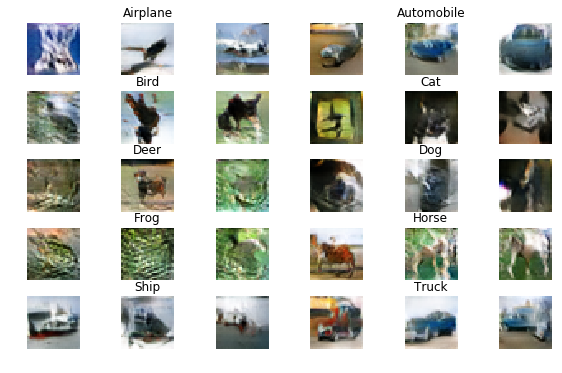

Epoch: 16; Gen. Loss: 0.319; Disc. Loss: 0.178, Acc: 0.940 (TEST)
Epoch: 17; Gen. Loss: 0.178; Disc. Loss: 0.141, Acc: 0.951 (TEST)
Epoch: 18; Gen. Loss: 0.065; Disc. Loss: 0.173, Acc: 0.936 (TEST)
Epoch: 19; Gen. Loss: 0.106; Disc. Loss: 0.068, Acc: 0.975 (TEST)
Epoch: 20; Gen. Loss: 0.552; Disc. Loss: 0.694, Acc: 0.801 (TEST)


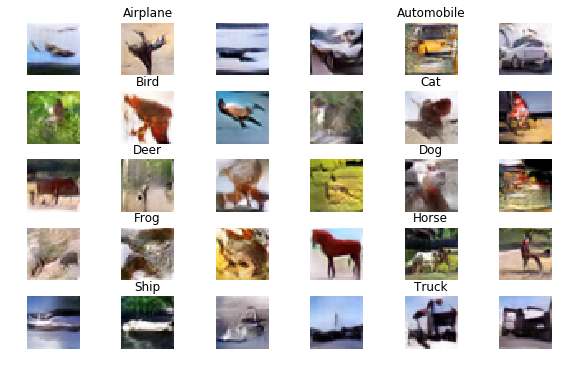

Epoch: 21; Gen. Loss: 0.016; Disc. Loss: 0.058, Acc: 0.984 (TEST)
Epoch: 22; Gen. Loss: 0.007; Disc. Loss: 0.121, Acc: 0.972 (TEST)
Epoch: 23; Gen. Loss: 0.001; Disc. Loss: 0.080, Acc: 0.974 (TEST)
Epoch: 24; Gen. Loss: 0.078; Disc. Loss: 0.134, Acc: 0.949 (TEST)
Epoch: 25; Gen. Loss: 0.420; Disc. Loss: 0.888, Acc: 0.772 (TEST)


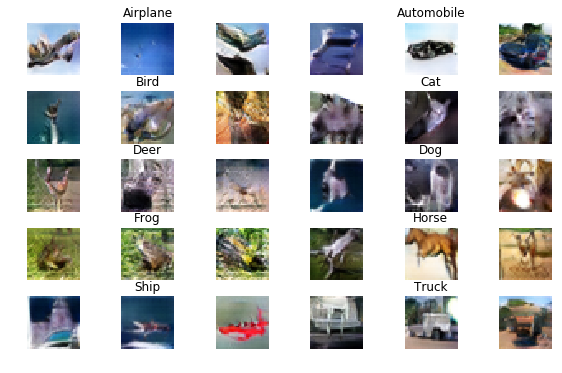

Epoch: 26; Gen. Loss: 0.095; Disc. Loss: 0.187, Acc: 0.941 (TEST)
Epoch: 27; Gen. Loss: 0.210; Disc. Loss: 0.476, Acc: 0.858 (TEST)
Epoch: 28; Gen. Loss: 0.034; Disc. Loss: 0.033, Acc: 0.987 (TEST)
Epoch: 29; Gen. Loss: 0.001; Disc. Loss: 0.087, Acc: 0.970 (TEST)
Epoch: 30; Gen. Loss: 0.018; Disc. Loss: 0.136, Acc: 0.958 (TEST)


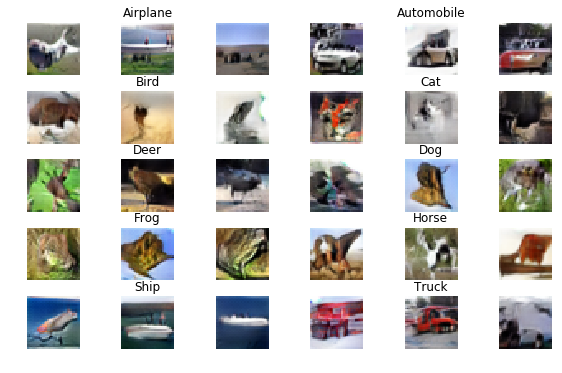

Epoch: 31; Gen. Loss: 0.094; Disc. Loss: 0.014, Acc: 0.995 (TEST)
Epoch: 32; Gen. Loss: 0.000; Disc. Loss: 0.030, Acc: 0.990 (TEST)
Epoch: 33; Gen. Loss: 0.000; Disc. Loss: 0.004, Acc: 0.999 (TEST)
Epoch: 34; Gen. Loss: 0.016; Disc. Loss: 0.136, Acc: 0.955 (TEST)
Epoch: 35; Gen. Loss: 0.198; Disc. Loss: 0.264, Acc: 0.925 (TEST)


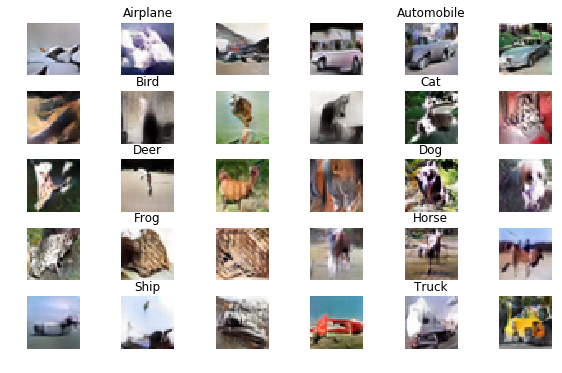

Epoch: 36; Gen. Loss: 0.144; Disc. Loss: 0.146, Acc: 0.952 (TEST)
Epoch: 37; Gen. Loss: 0.136; Disc. Loss: 0.164, Acc: 0.951 (TEST)
Epoch: 38; Gen. Loss: 0.347; Disc. Loss: 0.127, Acc: 0.960 (TEST)
Epoch: 39; Gen. Loss: 0.029; Disc. Loss: 0.168, Acc: 0.953 (TEST)
Epoch: 40; Gen. Loss: 0.015; Disc. Loss: 0.083, Acc: 0.978 (TEST)


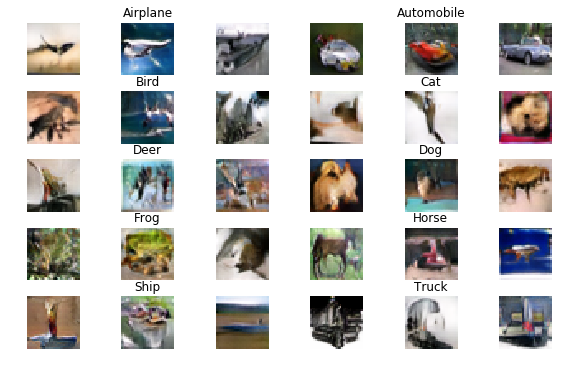

Epoch: 41; Gen. Loss: 0.276; Disc. Loss: 0.254, Acc: 0.942 (TEST)
Epoch: 42; Gen. Loss: 0.017; Disc. Loss: 0.078, Acc: 0.980 (TEST)
Epoch: 43; Gen. Loss: 0.001; Disc. Loss: 0.042, Acc: 0.989 (TEST)
Epoch: 44; Gen. Loss: 0.000; Disc. Loss: 0.011, Acc: 0.997 (TEST)
Epoch: 45; Gen. Loss: 0.000; Disc. Loss: 0.013, Acc: 0.997 (TEST)


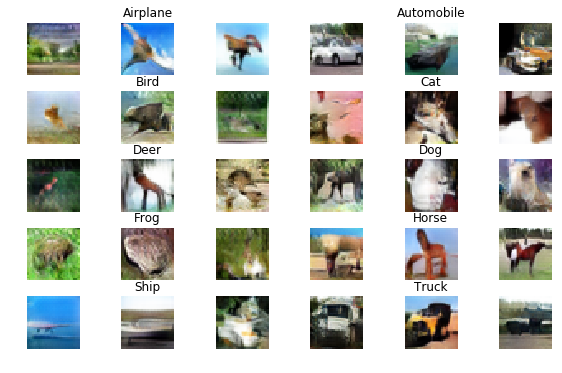

Epoch: 46; Gen. Loss: 0.000; Disc. Loss: 0.061, Acc: 0.988 (TEST)
Epoch: 47; Gen. Loss: 0.185; Disc. Loss: 0.078, Acc: 0.984 (TEST)
Epoch: 48; Gen. Loss: 0.003; Disc. Loss: 0.058, Acc: 0.988 (TEST)
Epoch: 49; Gen. Loss: 0.011; Disc. Loss: 0.483, Acc: 0.931 (TEST)
Epoch: 50; Gen. Loss: 0.120; Disc. Loss: 0.681, Acc: 0.894 (TEST)


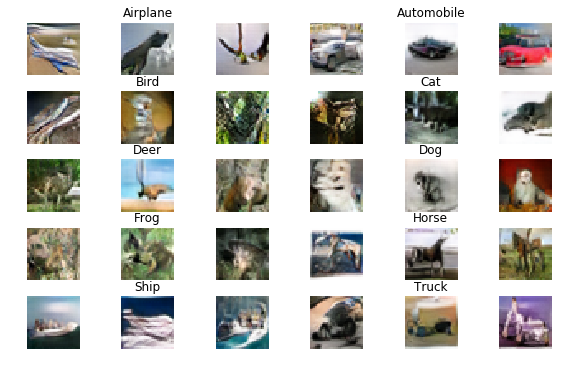

Epoch: 51; Gen. Loss: 1.302; Disc. Loss: 1.392, Acc: 0.798 (TEST)
Epoch: 52; Gen. Loss: 0.000; Disc. Loss: 0.099, Acc: 0.982 (TEST)
Epoch: 53; Gen. Loss: 1.229; Disc. Loss: 1.607, Acc: 0.805 (TEST)
Epoch: 54; Gen. Loss: 3.772; Disc. Loss: 3.034, Acc: 0.629 (TEST)
Epoch: 55; Gen. Loss: 2.617; Disc. Loss: 2.302, Acc: 0.685 (TEST)


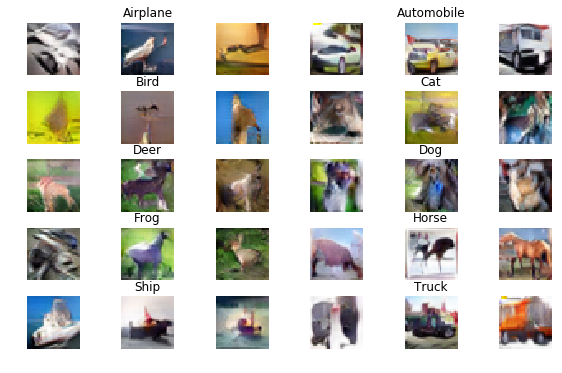

Epoch: 56; Gen. Loss: 0.583; Disc. Loss: 1.356, Acc: 0.823 (TEST)
Epoch: 57; Gen. Loss: 0.849; Disc. Loss: 1.040, Acc: 0.857 (TEST)
Epoch: 58; Gen. Loss: 0.724; Disc. Loss: 1.523, Acc: 0.809 (TEST)
Epoch: 59; Gen. Loss: 0.447; Disc. Loss: 1.067, Acc: 0.856 (TEST)
Epoch: 60; Gen. Loss: 4.089; Disc. Loss: 3.796, Acc: 0.628 (TEST)


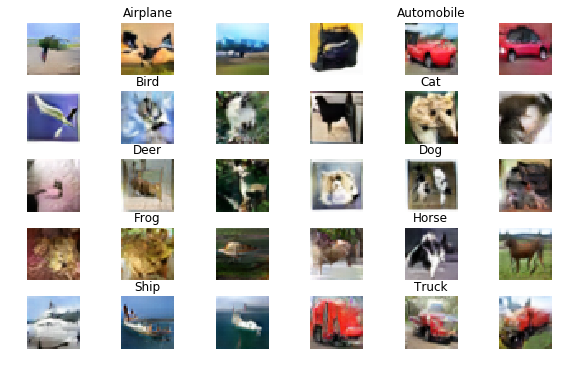

Epoch: 61; Gen. Loss: 2.479; Disc. Loss: 2.355, Acc: 0.735 (TEST)
Epoch: 62; Gen. Loss: 3.174; Disc. Loss: 3.347, Acc: 0.668 (TEST)
Epoch: 63; Gen. Loss: 1.392; Disc. Loss: 1.145, Acc: 0.859 (TEST)
Epoch: 64; Gen. Loss: 1.429; Disc. Loss: 1.292, Acc: 0.848 (TEST)
Epoch: 65; Gen. Loss: 0.003; Disc. Loss: 0.296, Acc: 0.961 (TEST)


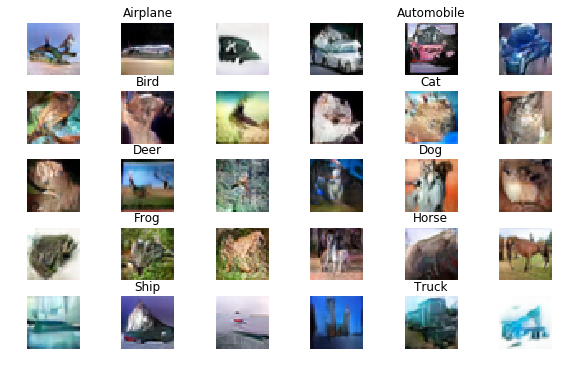

Epoch: 66; Gen. Loss: 1.300; Disc. Loss: 0.980, Acc: 0.887 (TEST)
Epoch: 67; Gen. Loss: 1.138; Disc. Loss: 1.063, Acc: 0.887 (TEST)
Epoch: 68; Gen. Loss: 0.611; Disc. Loss: 1.971, Acc: 0.818 (TEST)
Epoch: 69; Gen. Loss: 3.117; Disc. Loss: 3.052, Acc: 0.725 (TEST)
Epoch: 70; Gen. Loss: 1.662; Disc. Loss: 2.773, Acc: 0.751 (TEST)


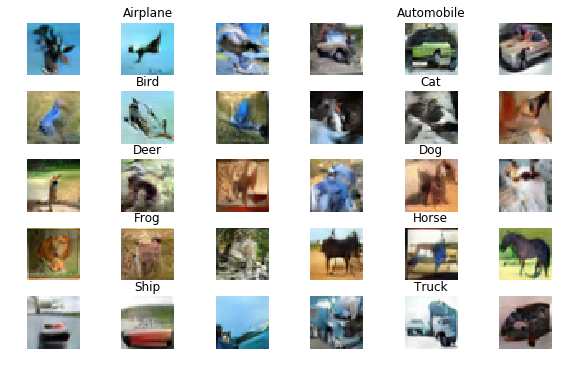

Epoch: 71; Gen. Loss: 3.236; Disc. Loss: 1.555, Acc: 0.855 (TEST)
Epoch: 72; Gen. Loss: 0.504; Disc. Loss: 0.430, Acc: 0.952 (TEST)
Epoch: 73; Gen. Loss: 1.132; Disc. Loss: 1.258, Acc: 0.873 (TEST)
Epoch: 74; Gen. Loss: 2.873; Disc. Loss: 1.897, Acc: 0.828 (TEST)
Epoch: 75; Gen. Loss: 3.305; Disc. Loss: 2.952, Acc: 0.727 (TEST)


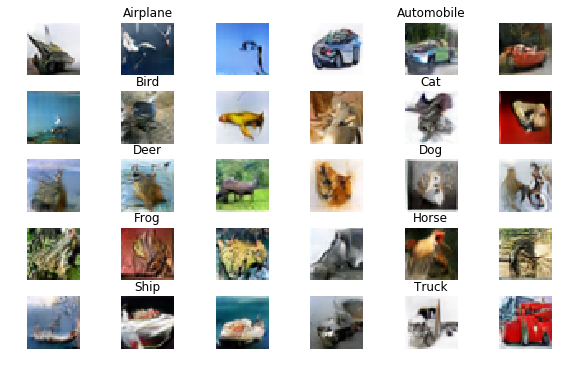

Epoch: 76; Gen. Loss: 0.325; Disc. Loss: 2.092, Acc: 0.818 (TEST)
Epoch: 77; Gen. Loss: 2.481; Disc. Loss: 3.239, Acc: 0.727 (TEST)
Epoch: 78; Gen. Loss: 0.029; Disc. Loss: 0.416, Acc: 0.962 (TEST)
Epoch: 79; Gen. Loss: 1.233; Disc. Loss: 1.863, Acc: 0.844 (TEST)
Epoch: 80; Gen. Loss: 0.399; Disc. Loss: 0.602, Acc: 0.946 (TEST)


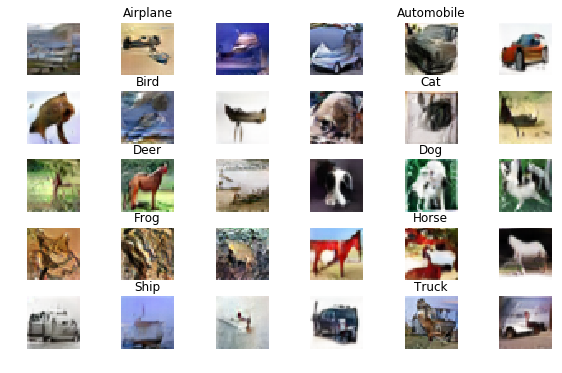

Epoch: 81; Gen. Loss: 0.000; Disc. Loss: 0.449, Acc: 0.957 (TEST)
Epoch: 82; Gen. Loss: 0.000; Disc. Loss: 0.366, Acc: 0.964 (TEST)
Epoch: 83; Gen. Loss: 1.277; Disc. Loss: 1.317, Acc: 0.888 (TEST)
Epoch: 84; Gen. Loss: 0.583; Disc. Loss: 1.751, Acc: 0.858 (TEST)
Epoch: 85; Gen. Loss: 0.505; Disc. Loss: 0.952, Acc: 0.921 (TEST)


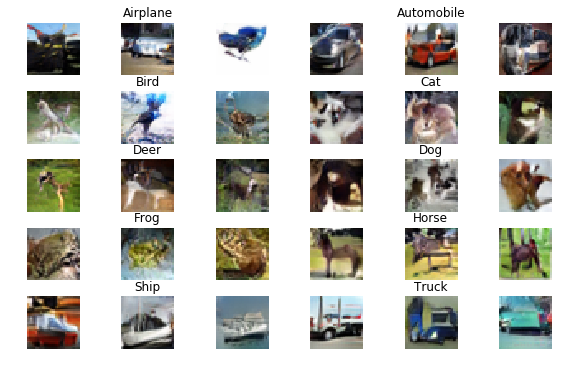

Epoch: 86; Gen. Loss: 1.020; Disc. Loss: 1.161, Acc: 0.901 (TEST)
Epoch: 87; Gen. Loss: 1.157; Disc. Loss: 2.870, Acc: 0.773 (TEST)
Epoch: 88; Gen. Loss: 1.034; Disc. Loss: 0.803, Acc: 0.929 (TEST)
Epoch: 89; Gen. Loss: 0.457; Disc. Loss: 0.886, Acc: 0.926 (TEST)
Epoch: 90; Gen. Loss: 0.004; Disc. Loss: 0.576, Acc: 0.950 (TEST)


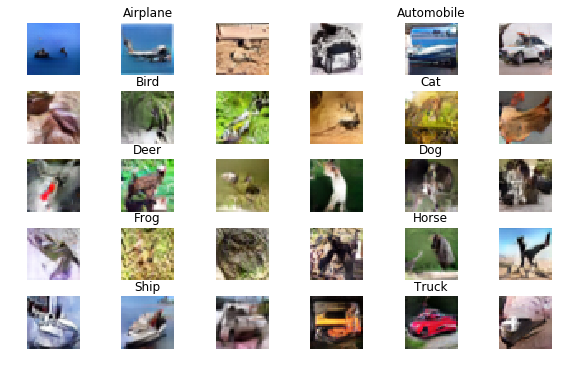

Epoch: 91; Gen. Loss: 0.000; Disc. Loss: 0.100, Acc: 0.991 (TEST)
Epoch: 92; Gen. Loss: 0.504; Disc. Loss: 0.577, Acc: 0.952 (TEST)
Epoch: 93; Gen. Loss: 0.915; Disc. Loss: 0.563, Acc: 0.951 (TEST)
Epoch: 94; Gen. Loss: 0.339; Disc. Loss: 0.947, Acc: 0.925 (TEST)
Epoch: 95; Gen. Loss: 0.478; Disc. Loss: 1.472, Acc: 0.882 (TEST)


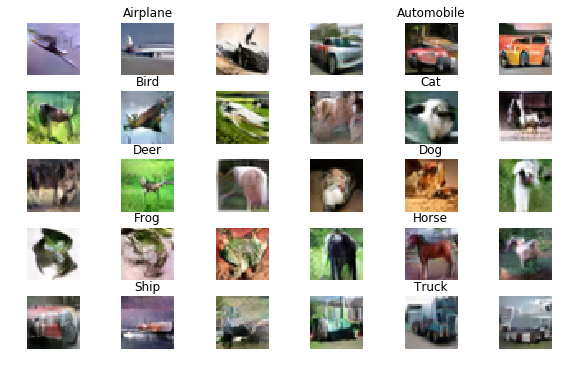

Epoch: 96; Gen. Loss: 1.181; Disc. Loss: 1.358, Acc: 0.890 (TEST)
Epoch: 97; Gen. Loss: 0.504; Disc. Loss: 1.323, Acc: 0.898 (TEST)
Epoch: 98; Gen. Loss: 2.881; Disc. Loss: 1.577, Acc: 0.879 (TEST)
Epoch: 99; Gen. Loss: 0.000; Disc. Loss: 0.561, Acc: 0.953 (TEST)
Epoch: 100; Gen. Loss: 0.504; Disc. Loss: 0.257, Acc: 0.977 (TEST)


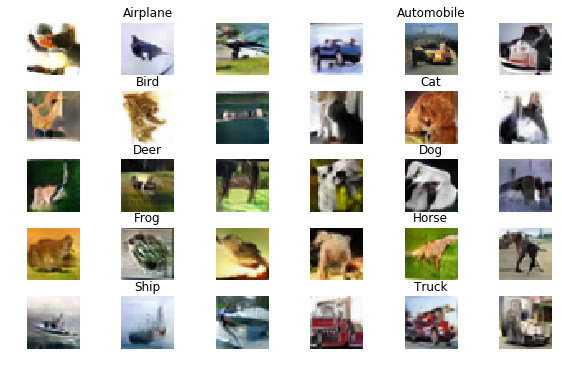

Epoch: 101; Gen. Loss: 0.504; Disc. Loss: 0.238, Acc: 0.980 (TEST)
Epoch: 102; Gen. Loss: 0.504; Disc. Loss: 0.833, Acc: 0.933 (TEST)
Epoch: 103; Gen. Loss: 0.000; Disc. Loss: 0.403, Acc: 0.968 (TEST)
Epoch: 104; Gen. Loss: 0.324; Disc. Loss: 0.839, Acc: 0.933 (TEST)
Epoch: 105; Gen. Loss: 0.000; Disc. Loss: 0.424, Acc: 0.964 (TEST)


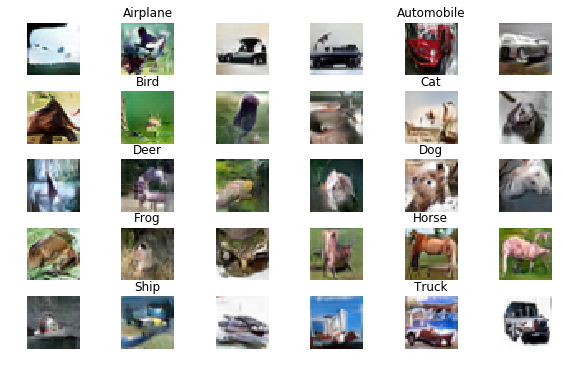

Epoch: 106; Gen. Loss: 0.620; Disc. Loss: 0.525, Acc: 0.957 (TEST)
Epoch: 107; Gen. Loss: 0.000; Disc. Loss: 0.119, Acc: 0.989 (TEST)
Epoch: 108; Gen. Loss: 0.000; Disc. Loss: 0.275, Acc: 0.977 (TEST)
Epoch: 109; Gen. Loss: 1.007; Disc. Loss: 1.018, Acc: 0.921 (TEST)
Epoch: 110; Gen. Loss: 0.001; Disc. Loss: 1.053, Acc: 0.915 (TEST)


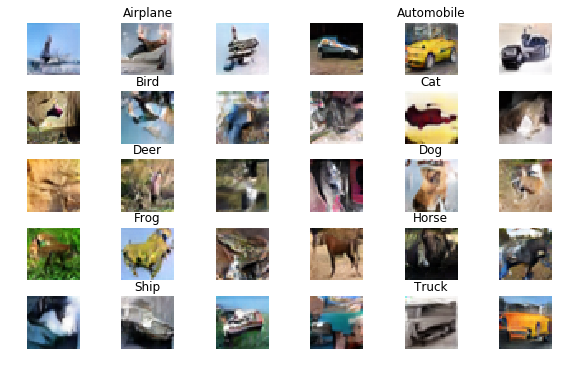

Epoch: 111; Gen. Loss: 0.000; Disc. Loss: 0.288, Acc: 0.976 (TEST)
Epoch: 112; Gen. Loss: 0.181; Disc. Loss: 0.980, Acc: 0.924 (TEST)
Epoch: 113; Gen. Loss: 1.011; Disc. Loss: 1.057, Acc: 0.918 (TEST)
Epoch: 114; Gen. Loss: 3.186; Disc. Loss: 3.397, Acc: 0.748 (TEST)
Epoch: 115; Gen. Loss: 3.011; Disc. Loss: 2.858, Acc: 0.797 (TEST)


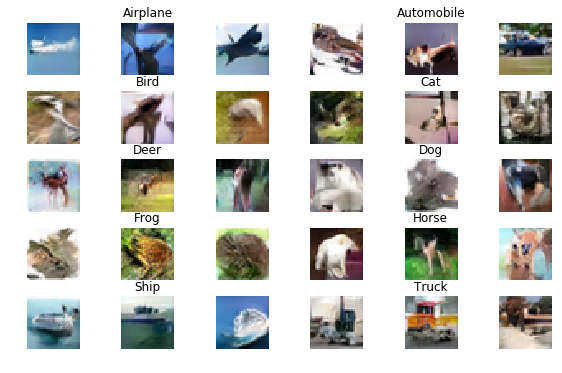

Epoch: 116; Gen. Loss: 2.721; Disc. Loss: 3.615, Acc: 0.745 (TEST)
Epoch: 117; Gen. Loss: 4.869; Disc. Loss: 4.857, Acc: 0.661 (TEST)
Epoch: 118; Gen. Loss: 1.011; Disc. Loss: 0.953, Acc: 0.925 (TEST)
Epoch: 119; Gen. Loss: 3.323; Disc. Loss: 2.352, Acc: 0.830 (TEST)
Epoch: 120; Gen. Loss: 0.507; Disc. Loss: 0.593, Acc: 0.956 (TEST)


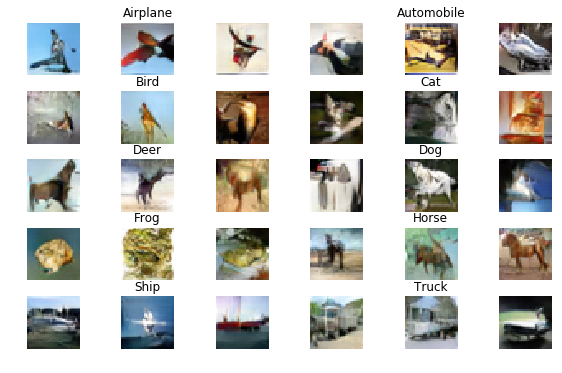

Epoch: 121; Gen. Loss: 1.978; Disc. Loss: 2.289, Acc: 0.836 (TEST)
Epoch: 122; Gen. Loss: 0.504; Disc. Loss: 1.146, Acc: 0.912 (TEST)
Epoch: 123; Gen. Loss: 0.200; Disc. Loss: 1.097, Acc: 0.918 (TEST)
Epoch: 124; Gen. Loss: 0.504; Disc. Loss: 0.529, Acc: 0.960 (TEST)
Epoch: 125; Gen. Loss: 0.754; Disc. Loss: 1.284, Acc: 0.904 (TEST)


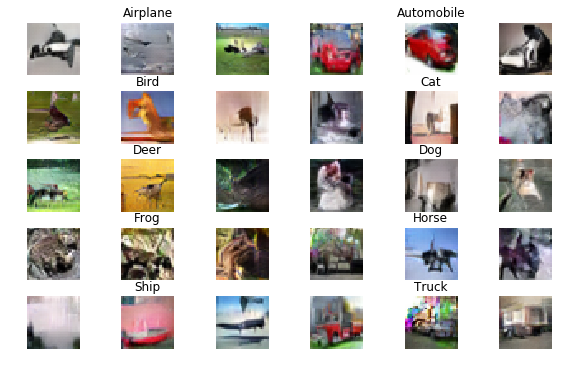

Epoch: 126; Gen. Loss: 4.091; Disc. Loss: 2.800, Acc: 0.798 (TEST)
Epoch: 127; Gen. Loss: 0.504; Disc. Loss: 0.292, Acc: 0.977 (TEST)
Epoch: 128; Gen. Loss: 0.504; Disc. Loss: 0.943, Acc: 0.933 (TEST)
Epoch: 129; Gen. Loss: 1.007; Disc. Loss: 1.091, Acc: 0.920 (TEST)
Epoch: 130; Gen. Loss: 0.504; Disc. Loss: 0.838, Acc: 0.941 (TEST)


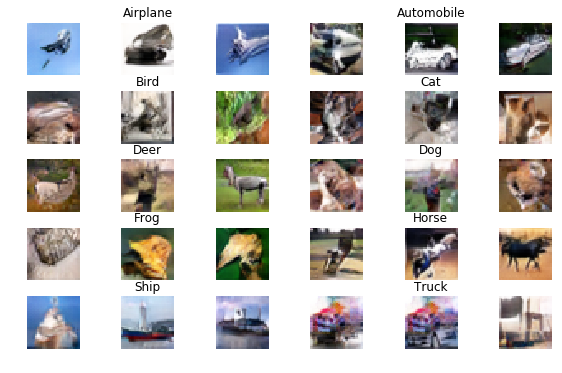

Epoch: 131; Gen. Loss: 0.001; Disc. Loss: 0.029, Acc: 0.997 (TEST)
Epoch: 132; Gen. Loss: 0.000; Disc. Loss: 0.166, Acc: 0.988 (TEST)
Epoch: 133; Gen. Loss: 0.504; Disc. Loss: 0.326, Acc: 0.974 (TEST)
Epoch: 134; Gen. Loss: 0.000; Disc. Loss: 0.510, Acc: 0.963 (TEST)
Epoch: 135; Gen. Loss: 0.199; Disc. Loss: 0.721, Acc: 0.947 (TEST)


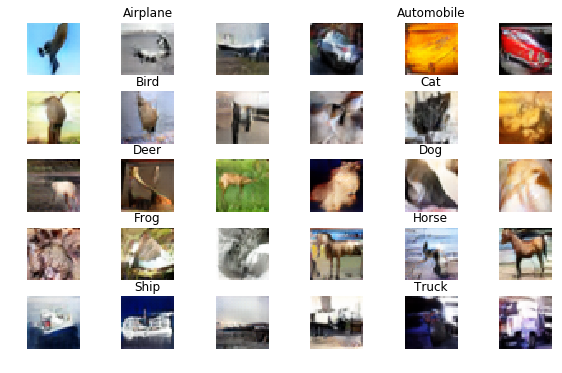

Epoch: 136; Gen. Loss: 3.179; Disc. Loss: 1.342, Acc: 0.904 (TEST)
Epoch: 137; Gen. Loss: 1.116; Disc. Loss: 1.416, Acc: 0.899 (TEST)
Epoch: 138; Gen. Loss: 0.607; Disc. Loss: 0.320, Acc: 0.977 (TEST)
Epoch: 139; Gen. Loss: 0.504; Disc. Loss: 0.886, Acc: 0.939 (TEST)
Epoch: 140; Gen. Loss: 0.000; Disc. Loss: 0.159, Acc: 0.988 (TEST)


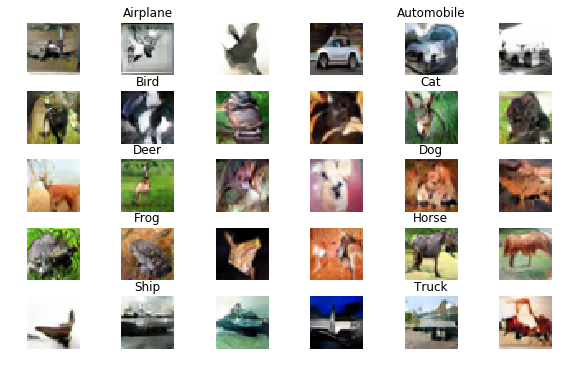

Epoch: 141; Gen. Loss: 2.005; Disc. Loss: 0.654, Acc: 0.954 (TEST)
Epoch: 142; Gen. Loss: 5.622; Disc. Loss: 4.334, Acc: 0.706 (TEST)
Epoch: 143; Gen. Loss: 3.528; Disc. Loss: 2.506, Acc: 0.827 (TEST)
Epoch: 144; Gen. Loss: 2.031; Disc. Loss: 3.554, Acc: 0.762 (TEST)
Epoch: 145; Gen. Loss: 1.975; Disc. Loss: 3.014, Acc: 0.794 (TEST)


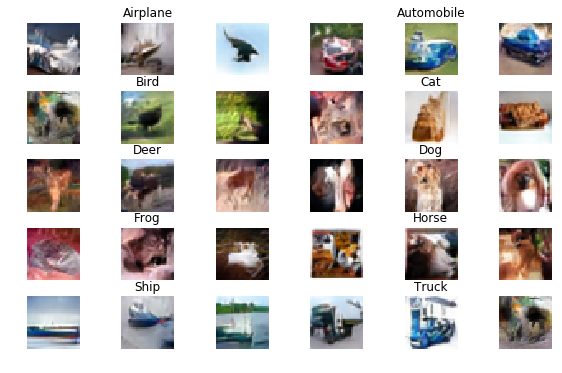

Epoch: 146; Gen. Loss: 7.749; Disc. Loss: 6.056, Acc: 0.603 (TEST)
Epoch: 147; Gen. Loss: 5.503; Disc. Loss: 4.524, Acc: 0.703 (TEST)
Epoch: 148; Gen. Loss: 2.016; Disc. Loss: 1.637, Acc: 0.888 (TEST)
Epoch: 149; Gen. Loss: 4.248; Disc. Loss: 2.847, Acc: 0.808 (TEST)
Epoch: 150; Gen. Loss: 0.504; Disc. Loss: 0.662, Acc: 0.956 (TEST)


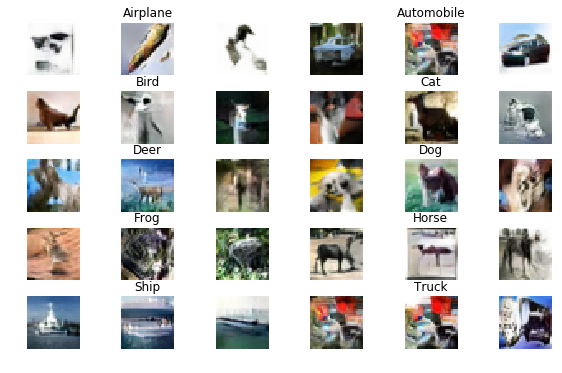

Epoch: 151; Gen. Loss: 3.463; Disc. Loss: 0.635, Acc: 0.957 (TEST)
Epoch: 152; Gen. Loss: 1.511; Disc. Loss: 0.507, Acc: 0.967 (TEST)
Epoch: 153; Gen. Loss: 3.022; Disc. Loss: 2.761, Acc: 0.820 (TEST)
Epoch: 154; Gen. Loss: 4.593; Disc. Loss: 3.521, Acc: 0.771 (TEST)
Epoch: 155; Gen. Loss: 6.976; Disc. Loss: 3.823, Acc: 0.753 (TEST)


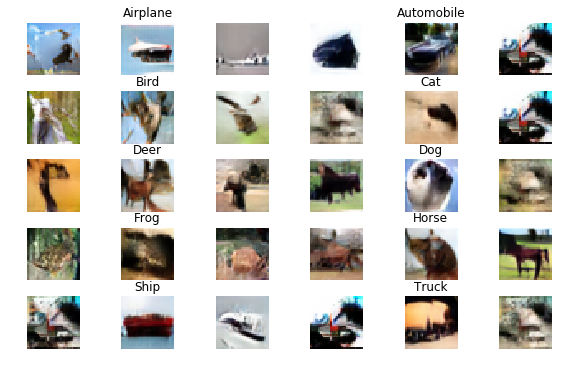

Epoch: 156; Gen. Loss: 2.526; Disc. Loss: 4.361, Acc: 0.718 (TEST)
Epoch: 157; Gen. Loss: 3.028; Disc. Loss: 2.730, Acc: 0.820 (TEST)
Epoch: 158; Gen. Loss: 3.716; Disc. Loss: 4.000, Acc: 0.738 (TEST)
Epoch: 159; Gen. Loss: 2.607; Disc. Loss: 1.775, Acc: 0.886 (TEST)
Epoch: 160; Gen. Loss: 2.862; Disc. Loss: 4.001, Acc: 0.744 (TEST)


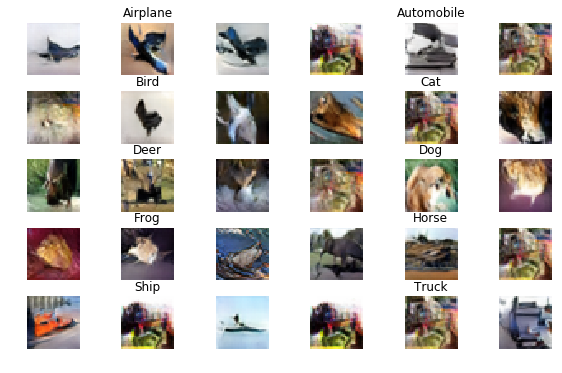

Epoch: 161; Gen. Loss: 6.961; Disc. Loss: 6.046, Acc: 0.610 (TEST)
Epoch: 162; Gen. Loss: 7.052; Disc. Loss: 8.585, Acc: 0.454 (TEST)
Epoch: 163; Gen. Loss: 9.266; Disc. Loss: 8.887, Acc: 0.434 (TEST)
Epoch: 164; Gen. Loss: 6.044; Disc. Loss: 7.368, Acc: 0.527 (TEST)
Epoch: 165; Gen. Loss: 10.074; Disc. Loss: 10.143, Acc: 0.358 (TEST)


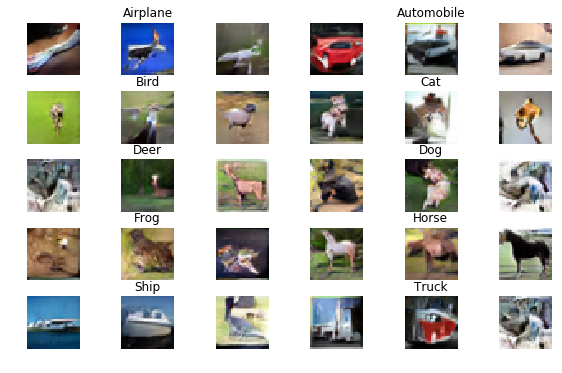

Epoch: 166; Gen. Loss: 3.359; Disc. Loss: 3.391, Acc: 0.782 (TEST)
Epoch: 167; Gen. Loss: 4.828; Disc. Loss: 4.556, Acc: 0.706 (TEST)
Epoch: 168; Gen. Loss: 3.858; Disc. Loss: 5.629, Acc: 0.639 (TEST)
Epoch: 169; Gen. Loss: 2.015; Disc. Loss: 1.815, Acc: 0.882 (TEST)
Epoch: 170; Gen. Loss: 8.073; Disc. Loss: 6.478, Acc: 0.586 (TEST)


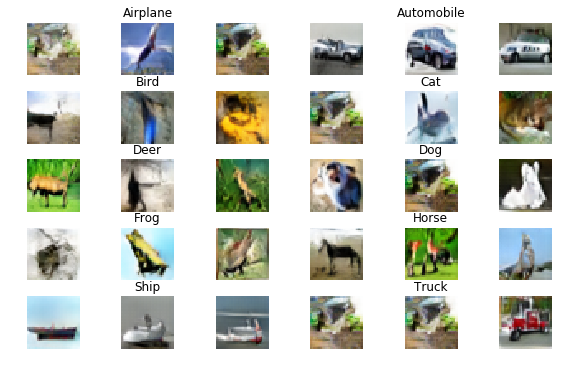

Epoch: 171; Gen. Loss: 3.305; Disc. Loss: 1.979, Acc: 0.871 (TEST)
Epoch: 172; Gen. Loss: 5.037; Disc. Loss: 3.900, Acc: 0.748 (TEST)
Epoch: 173; Gen. Loss: 2.801; Disc. Loss: 3.765, Acc: 0.757 (TEST)
Epoch: 174; Gen. Loss: 6.071; Disc. Loss: 8.343, Acc: 0.473 (TEST)
Epoch: 175; Gen. Loss: 5.974; Disc. Loss: 6.060, Acc: 0.613 (TEST)


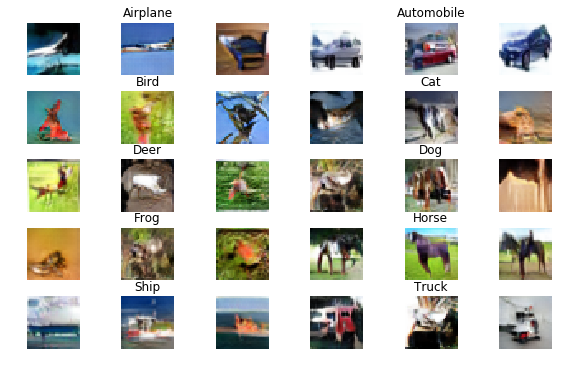

Epoch: 176; Gen. Loss: 4.030; Disc. Loss: 5.486, Acc: 0.649 (TEST)
Epoch: 177; Gen. Loss: 5.403; Disc. Loss: 4.621, Acc: 0.703 (TEST)
Epoch: 178; Gen. Loss: 4.030; Disc. Loss: 4.757, Acc: 0.697 (TEST)
Epoch: 179; Gen. Loss: 5.146; Disc. Loss: 4.787, Acc: 0.693 (TEST)
Epoch: 180; Gen. Loss: 13.309; Disc. Loss: 11.042, Acc: 0.304 (TEST)


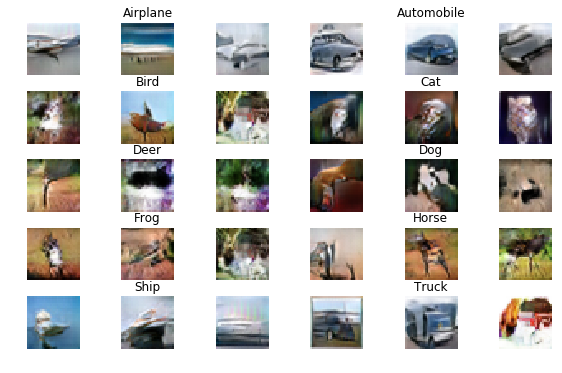

Epoch: 181; Gen. Loss: 8.563; Disc. Loss: 3.776, Acc: 0.756 (TEST)
Epoch: 182; Gen. Loss: 11.081; Disc. Loss: 13.028, Acc: 0.186 (TEST)
Epoch: 183; Gen. Loss: 8.988; Disc. Loss: 10.281, Acc: 0.344 (TEST)
Epoch: 184; Gen. Loss: 12.914; Disc. Loss: 13.851, Acc: 0.134 (TEST)
Epoch: 185; Gen. Loss: 14.103; Disc. Loss: 14.233, Acc: 0.115 (TEST)


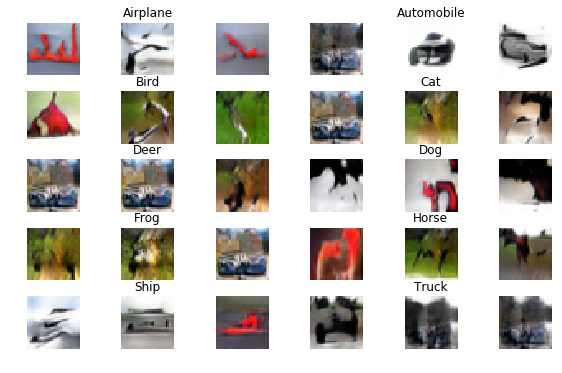

Epoch: 186; Gen. Loss: 14.103; Disc. Loss: 13.868, Acc: 0.136 (TEST)
Epoch: 187; Gen. Loss: 14.869; Disc. Loss: 11.723, Acc: 0.263 (TEST)
Epoch: 188; Gen. Loss: 8.563; Disc. Loss: 9.833, Acc: 0.372 (TEST)
Epoch: 189; Gen. Loss: 8.409; Disc. Loss: 8.185, Acc: 0.479 (TEST)
Epoch: 190; Gen. Loss: 10.074; Disc. Loss: 8.027, Acc: 0.489 (TEST)


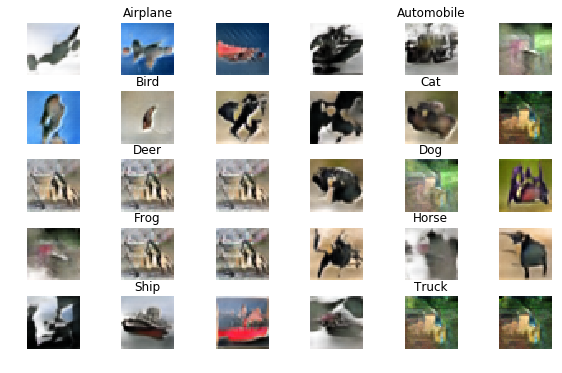

Epoch: 191; Gen. Loss: 10.579; Disc. Loss: 8.902, Acc: 0.437 (TEST)
Epoch: 192; Gen. Loss: 11.585; Disc. Loss: 11.219, Acc: 0.300 (TEST)
Epoch: 193; Gen. Loss: 8.563; Disc. Loss: 6.361, Acc: 0.596 (TEST)
Epoch: 194; Gen. Loss: 11.585; Disc. Loss: 9.956, Acc: 0.376 (TEST)
Epoch: 195; Gen. Loss: 11.081; Disc. Loss: 4.088, Acc: 0.741 (TEST)


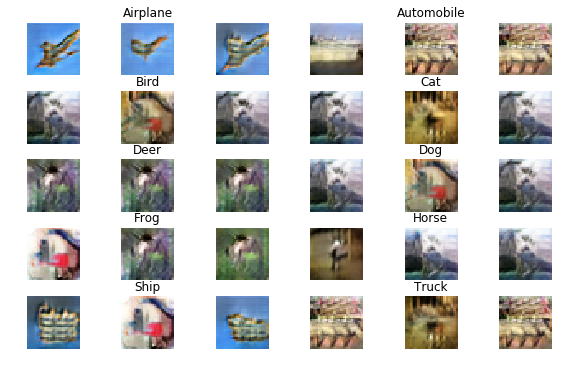

Epoch: 196; Gen. Loss: 0.000; Disc. Loss: 0.200, Acc: 0.987 (TEST)
Epoch: 197; Gen. Loss: 5.037; Disc. Loss: 2.395, Acc: 0.848 (TEST)
Epoch: 198; Gen. Loss: 0.000; Disc. Loss: 1.680, Acc: 0.893 (TEST)
Epoch: 199; Gen. Loss: 0.000; Disc. Loss: 0.005, Acc: 1.000 (TEST)
Epoch: 200; Gen. Loss: 0.000; Disc. Loss: 0.013, Acc: 0.999 (TEST)


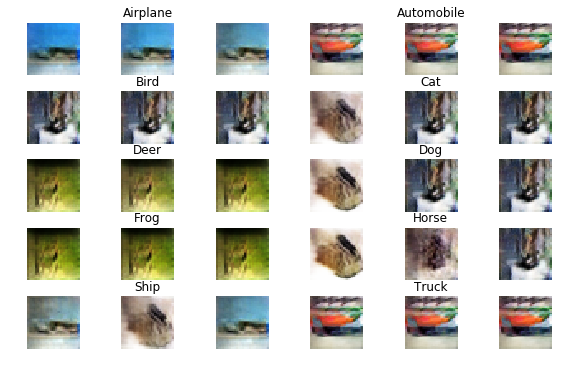

In [8]:
# --------
# Train and test
# --------

EPOCHS =  200
d_accs_train = []
d_losses_train = []
d_losses_test = []
d_accs_test   = []
g_losses_test = []

# Prepare labels as ground truth of discrimination output
true_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

print("Training started. Printed losses and accuracies were on test data.")
for epoch in range(EPOCHS):
    
    # shuffle all data on starting epoch
    s = np.arange(X_train.shape[0])
    np.random.shuffle(s)
    X_train = X_train[s]
    c_train = c_train[s]
    
    # Train every batch
    d_losses_train_in_epoch = []
    d_accs_train_in_epoch = []
    for batch_idx_train in range(num_train_batches):
        # Get the set of images and labels (here used as conditions) from CIFAR-10 dataset
        true_images      = X_train[batch_idx_train * BATCH_SIZE : (batch_idx_train + 1) * BATCH_SIZE]
        true_conditions  = c_train[batch_idx_train * BATCH_SIZE : (batch_idx_train + 1) * BATCH_SIZE]

        noise_data        = generate_noise(BATCH_SIZE, 100)
        random_conditions = generate_random_labels(BATCH_SIZE)
        generated_images  = generator.predict([noise_data, random_conditions])

        # Train discriminator on real data whose label is one
        d_loss_true_train = discriminator.train_on_batch([true_images, true_conditions], true_labels)

        # Train discriminator on generated data whose label is zero
        d_loss_fake       = discriminator.train_on_batch([generated_images, random_conditions], fake_labels)

        # Train generator. Generator tries to cheat discriminator so a label need set to be one
        # Learning goes on so that a network produces labels
        # generator has 1.5 times the number of trainable parameters than discriminator
        # discriminator.train_on_batch runs two times above, so combined.train_on_batch three times.
        g_loss_train      = combined.train_on_batch([noise_data, random_conditions], true_labels)
        noise_data        = generate_noise(BATCH_SIZE, 100)
        g_loss_train      = combined.train_on_batch([noise_data, random_conditions], true_labels)
        noise_data        = generate_noise(BATCH_SIZE, 100)
        g_loss_train      = combined.train_on_batch([noise_data, random_conditions], true_labels)

        d_losses_train_in_epoch.append(d_loss_true_train[0])
        d_accs_train_in_epoch.append(d_loss_true_train[1])
        
    d_loss_train = np.average(d_losses_train_in_epoch)
    d_acc_train = np.average(d_accs_train_in_epoch)
    d_losses_train.append(d_loss_train)
    d_accs_train.append(d_acc_train)
    
    # Test at the end of every epoch
    # store discriminator's and generator's loss at every batch and then calculate average at the end of epoch 
    d_losses_in_epoch = []
    d_accs_in_epoch = []
    g_losses_in_epoch = []
    for batch_idx_test in range(num_test_batches):
        test_images     = X_test[batch_idx_test * BATCH_SIZE : (batch_idx_test + 1) * BATCH_SIZE]
        test_conditions = c_test[batch_idx_test * BATCH_SIZE : (batch_idx_test + 1) * BATCH_SIZE]

        d_loss_test_batch = discriminator.test_on_batch([test_images, test_conditions], true_labels)
        g_loss_test_batch = combined.test_on_batch([noise_data, random_conditions], true_labels)

        d_losses_in_epoch.append(d_loss_test_batch[0])
        d_accs_in_epoch.append(d_loss_test_batch[1])
        g_losses_in_epoch.append(g_loss_test_batch)
        
    d_loss_test = np.average(d_losses_in_epoch)
    d_acc_test  = np.average(d_accs_in_epoch)
    g_loss_test = np.average(g_losses_in_epoch)

    d_losses_test.append(d_loss_test)
    d_accs_test.append(d_acc_test)
    g_losses_test.append(g_loss_test)
    print('Epoch: {}; Gen. Loss: {:.3f}; Disc. Loss: {:.3f}, Acc: {:.3f}'.format(epoch + 1, g_loss_test, d_loss_test, d_acc_test))
    if (epoch + 1) % 5 == 0:
        show_samples()

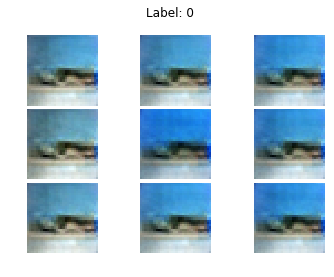

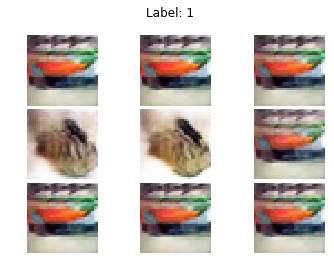

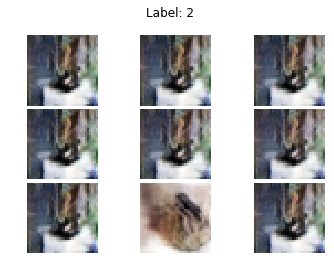

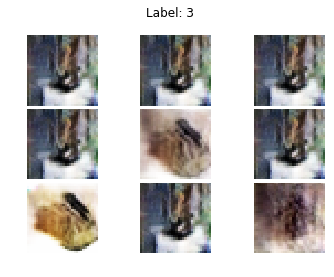

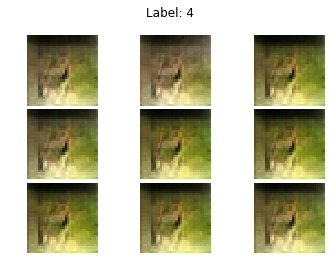

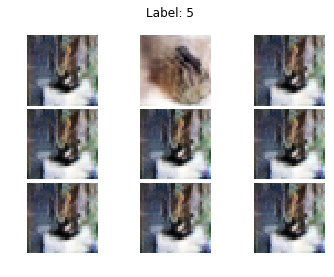

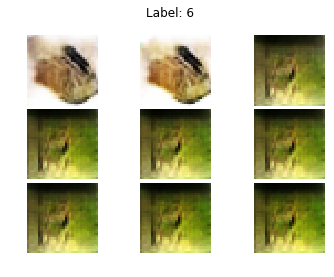

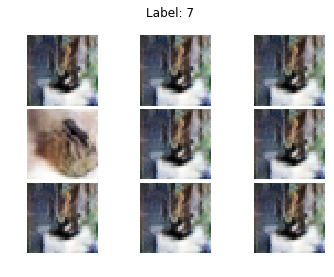

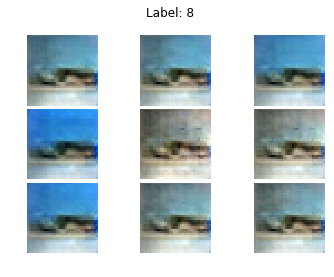

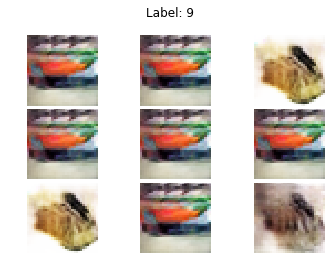

In [9]:
for classlabel in range(10):
    lbls = one_hot_encode([classlabel] * 9)
    noise = generate_noise(9, 100)
    gen_imgs = generator.predict([noise, lbls])

    fig, axs = plt.subplots(3, 3)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    count = 0
    for i in range(3):
        for j in range(3):
            # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[count], scale=True)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            plt.suptitle('Label: ' + str(classlabel))
            count += 1
    plt.show()
    plt.close()  

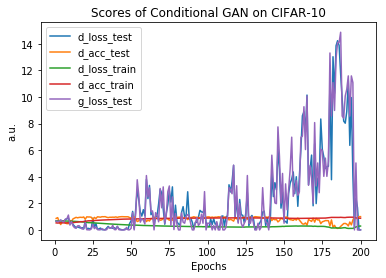

In [12]:
# --------
# Plot generator and discriminator accuracy and loss all
# --------
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i + 1 for i in range(len(d_losses_train))]
plt.plot(x, d_losses_test,  label="d_loss_test")
plt.plot(x, d_accs_test,     label="d_acc_test")
plt.plot(x, d_losses_train, label='d_loss_train')
plt.plot(x, d_accs_train,   label="d_acc_train")
plt.plot(x, g_losses_test,  label="g_loss_test")
plt.xlabel('Epochs')
plt.ylabel('a.u.')
plt.legend()
plt.title('Scores of Conditional GAN on CIFAR-10')
plt.show()

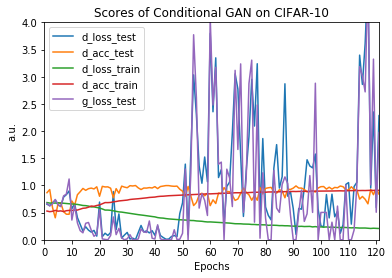

In [18]:
# --------
# Plot generator and discriminator accuracy and loss focusing on beginning
# --------
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i + 1 for i in range(len(d_losses_train))]
plt.plot(x, d_losses_test,  label="d_loss_test")
plt.plot(x, d_accs_test,    label="d_acc_test")
plt.plot(x, d_losses_train, label='d_loss_train')
plt.plot(x, d_accs_train,   label="d_acc_train")
plt.plot(x, g_losses_test,  label="g_loss_test")
plt.xlabel('Epochs')
plt.ylabel('a.u.')
plt.xlim((-0,121))
plt.ylim((0, 4))
ax = plt.gca()
ax.set_xticks(ticks = [i for i in range(0, 121, 10)])
plt.legend()
plt.title('Scores of Conditional GAN on CIFAR-10')
plt.show()